### GAN
- [https://github.com/jonbruner/generative-adversarial-networks/blob/master/gan-script.py](https://github.com/jonbruner/generative-adversarial-networks/blob/master/gan-script.py) 
<br>
From [https://www.oreilly.com/learning/generative-adversarial-networks-for-beginners](https://www.oreilly.com/learning/generative-adversarial-networks-for-beginners)
<br>
- [https://github.com/diegoalejogm/gans](https://github.com/diegoalejogm/gans)

![diagram](images/diagram.png)

[diagram](https://www.draw.io/#G17bPIBw8J0l-u_aD3TjViTyJ5l-3az0bz)

In [1]:
%matplotlib inline

In [2]:
import tensorflow as tf
import numpy as np
import datetime
import matplotlib.pyplot as plt
import cv2
from IPython import display

# Load MNIST data
# from tensorflow.examples.tutorials.mnist import input_data
# mnist = input_data.read_data_sets("MNIST_data/")

/Users/epinyoanun/miniconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
# Define the discriminator network
def discriminator(images, reuse_variables=None):
    with tf.variable_scope(tf.get_variable_scope(), reuse=reuse_variables) as scope:
        # First convolutional and pool layers
        # This finds 32 different 5 x 5 pixel features
        d_w1 = tf.get_variable('d_w1', [5, 5, 1, 32], initializer=tf.truncated_normal_initializer(stddev=0.02))
        d_b1 = tf.get_variable('d_b1', [32], initializer=tf.constant_initializer(0))
        d1 = tf.nn.conv2d(input=images, filter=d_w1, strides=[1, 1, 1, 1], padding='SAME')
        d1 = d1 + d_b1
        d1 = tf.nn.relu(d1)
        d1 = tf.nn.avg_pool(d1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

        # Second convolutional and pool layers
        # This finds 64 different 5 x 5 pixel features
        d_w2 = tf.get_variable('d_w2', [5, 5, 32, 64], initializer=tf.truncated_normal_initializer(stddev=0.02))
        d_b2 = tf.get_variable('d_b2', [64], initializer=tf.constant_initializer(0))
        d2 = tf.nn.conv2d(input=d1, filter=d_w2, strides=[1, 1, 1, 1], padding='SAME')
        d2 = d2 + d_b2
        d2 = tf.nn.relu(d2)
        d2 = tf.nn.avg_pool(d2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

        # First fully connected layer
        d_w3 = tf.get_variable('d_w3', [7 * 7 * 64, 1024], initializer=tf.truncated_normal_initializer(stddev=0.02))
        d_b3 = tf.get_variable('d_b3', [1024], initializer=tf.constant_initializer(0))
        d3 = tf.reshape(d2, [-1, 7 * 7 * 64])
        d3 = tf.matmul(d3, d_w3)
        d3 = d3 + d_b3
        d3 = tf.nn.relu(d3)

        # Second fully connected layer
        d_w4 = tf.get_variable('d_w4', [1024, 1], initializer=tf.truncated_normal_initializer(stddev=0.02))
        d_b4 = tf.get_variable('d_b4', [1], initializer=tf.constant_initializer(0))
        d4 = tf.matmul(d3, d_w4) + d_b4

        # d4 contains unscaled values
        return d4

# Define the generator network
# TODO remove batch_size???
def generator(z, batch_size, z_dim):
    g_w1 = tf.get_variable('g_w1', [z_dim, 3136], dtype=tf.float32, initializer=tf.truncated_normal_initializer(stddev=0.02))
    g_b1 = tf.get_variable('g_b1', [3136], initializer=tf.truncated_normal_initializer(stddev=0.02))
    g1 = tf.matmul(z, g_w1) + g_b1
    g1 = tf.reshape(g1, [-1, 56, 56, 1])
    g1 = tf.contrib.layers.batch_norm(g1, epsilon=1e-5, scope='g_b1')
    g1 = tf.nn.relu(g1)

    # Generate 50 features
    g_w2 = tf.get_variable('g_w2', [3, 3, 1, z_dim/2], dtype=tf.float32, initializer=tf.truncated_normal_initializer(stddev=0.02))
    g_b2 = tf.get_variable('g_b2', [z_dim/2], initializer=tf.truncated_normal_initializer(stddev=0.02))
    g2 = tf.nn.conv2d(g1, g_w2, strides=[1, 2, 2, 1], padding='SAME')
    g2 = g2 + g_b2
    g2 = tf.contrib.layers.batch_norm(g2, epsilon=1e-5, scope='g_b2')
    g2 = tf.nn.relu(g2)
    g2 = tf.image.resize_images(g2, [56, 56])

    # Generate 25 features
    g_w3 = tf.get_variable('g_w3', [3, 3, z_dim/2, z_dim/4], dtype=tf.float32, initializer=tf.truncated_normal_initializer(stddev=0.02))
    g_b3 = tf.get_variable('g_b3', [z_dim/4], initializer=tf.truncated_normal_initializer(stddev=0.02))
    g3 = tf.nn.conv2d(g2, g_w3, strides=[1, 2, 2, 1], padding='SAME')
    g3 = g3 + g_b3
    g3 = tf.contrib.layers.batch_norm(g3, epsilon=1e-5, scope='g_b3')
    g3 = tf.nn.relu(g3)
    g3 = tf.image.resize_images(g3, [56, 56])

    # Final convolution with one output channel
    g_w4 = tf.get_variable('g_w4', [1, 1, z_dim/4, 1], dtype=tf.float32, initializer=tf.truncated_normal_initializer(stddev=0.02))
    g_b4 = tf.get_variable('g_b4', [1], initializer=tf.truncated_normal_initializer(stddev=0.02))
    g4 = tf.nn.conv2d(g3, g_w4, strides=[1, 2, 2, 1], padding='SAME')
    g4 = g4 + g_b4
    g4 = tf.sigmoid(g4)

    # Dimensions of g4: batch_size x 28 x 28 x 1
    return g4

In [4]:
z_dimensions = 100
batch_size = 50

# z is the noise for Generator
z_placeholder = tf.placeholder(tf.float32, [None, z_dimensions], name='z_placeholder')
generator_z = generator(z_placeholder, batch_size, z_dimensions)

# x is the source data for Discreminator
x_placeholder = tf.placeholder(tf.float32, shape = [None,28,28,1], name='x_placeholder')
discriminator_x = discriminator(x_placeholder)
discriminator_generator = discriminator(generator_z, reuse_variables=True)

loss_discriminator_real = tf.reduce_mean(
                            tf.nn.sigmoid_cross_entropy_with_logits(
                                logits = discriminator_x, 
                                labels = tf.ones_like(discriminator_x)
                            )
                          )
loss_discriminator_fake = tf.reduce_mean(
                            tf.nn.sigmoid_cross_entropy_with_logits(
                                logits = discriminator_generator, 
                                labels = tf.zeros_like(discriminator_generator)
                            )
                          )
loss_generator = tf.reduce_mean(
                    tf.nn.sigmoid_cross_entropy_with_logits(
                        logits = discriminator_generator, 
                        labels = tf.ones_like(discriminator_generator)
                    )
                 )
tf.ones_like

Instructions for updating:
Use the retry module or similar alternatives.


<function tensorflow.python.ops.array_ops.ones_like(tensor, dtype=None, name=None, optimize=True)>

In [5]:
# Define variable lists
tvars = tf.trainable_variables()
vars_discriminator = [var for var in tvars if 'd_' in var.name]
vars_generator = [var for var in tvars if 'g_' in var.name]

# Define the optimizers
# Train the discriminatora
trainer_discriminator_fake = tf.train.AdamOptimizer(0.0003).minimize(
                                loss_discriminator_fake, 
                                var_list=vars_discriminator # update only variable of discriminator
                             )
trainer_discriminator_real = tf.train.AdamOptimizer(0.0003).minimize(
                                loss_discriminator_real, 
                                var_list=vars_discriminator # update only variable of discriminator
                             )

# Train the generator
trainer_generator = tf.train.AdamOptimizer(0.0001).minimize(
                                loss_generator, 
                                var_list=vars_generator # update only variable of generator
                    )

In [6]:
# From this point forward, reuse variables
tf.get_variable_scope().reuse_variables()
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

## Train

#### helper

In [7]:
def random_rect():
    img = np.zeros((28,28,1), np.uint8)
    x1 = np.random.randint(0, 20)
    y1 = np.random.randint(0, 20)
    x2 = np.random.randint(x1, 28)
    y2 = np.random.randint(x2, 28)
    cv2.rectangle(img,(x1, y1), (x2, y2),(1), -1)
#     plt.imshow(img.reshape(28, 28), cmap='gist_gray')
    return img
def random_rects(num):
    images = []
    for i in range(num):
        images.append(random_rect())
    return np.array(images)

random_rects(50).shape

(50, 28, 28, 1)

#### Plot function helper

In [8]:
row = 4
column = 4
def plot_batch_images(batch_images):
    figure = plt.figure(figsize=(10, 10))
    for i in range(_generate_image.shape[0]):
        figure.add_subplot(row, column, i+1)
        plt.axis('off')
        plt.imshow(batch_images[i].reshape(28, 28), cmap='gist_gray')
    display.display(plt.gcf())
    plt.close()

#### Run Session

In [9]:
def run_session_train_discriminator():
    z_batch = np.random.normal(0, 1, size=[batch_size, z_dimensions])
#     real_image_batch = mnist.train.next_batch(batch_size)[0].reshape([batch_size, 28, 28, 1])
    real_image_batch = random_rects(50).reshape([batch_size, 28, 28, 1])
    return sess.run([
                    trainer_discriminator_real, 
                    trainer_discriminator_fake, 
                    loss_discriminator_real, 
                    loss_discriminator_fake
                   ],
                   {
                    x_placeholder: real_image_batch, 
                    z_placeholder: z_batch
                   })

In [10]:
def run_session_train_generator():
    z_batch = np.random.normal(0, 1, size=[batch_size, z_dimensions])
    return sess.run([
                        trainer_generator, 
                        loss_generator
                    ] , 
                    feed_dict={
                        z_placeholder: z_batch
                    })

### Test

In [11]:
num_test_samples = 16
generate_test = generator(z_placeholder, num_test_samples, z_dimensions)
def run_session_test():
    z_batch = np.random.normal(0, 1, size=[num_test_samples, z_dimensions])
    return sess.run(generate_test,  feed_dict={ z_placeholder: z_batch })

### Train Discriminator
Discriminitor should be better than generator (to tell generator good or bad)

In [12]:
for i in range(300):
    _, __, _loss_discriminator_real, _loss_discriminator_fake = run_session_train_discriminator()
    if i%10==0:
        print('_loss_discriminator_real:', _loss_discriminator_real, 
              '_loss_discriminator_fake:', _loss_discriminator_fake)

_loss_discriminator_real: 0.69329476 _loss_discriminator_fake: 0.7094936
_loss_discriminator_real: 0.66984004 _loss_discriminator_fake: 0.7123817
_loss_discriminator_real: 0.6121781 _loss_discriminator_fake: 0.7484052
_loss_discriminator_real: 0.51777977 _loss_discriminator_fake: 0.822513
_loss_discriminator_real: 0.43277383 _loss_discriminator_fake: 0.9207193
_loss_discriminator_real: 0.36926907 _loss_discriminator_fake: 0.9830324
_loss_discriminator_real: 0.30592197 _loss_discriminator_fake: 0.89180565
_loss_discriminator_real: 0.19148642 _loss_discriminator_fake: 0.8307801
_loss_discriminator_real: 0.08054672 _loss_discriminator_fake: 0.7270413
_loss_discriminator_real: 0.047315225 _loss_discriminator_fake: 0.61372286
_loss_discriminator_real: 0.0064638164 _loss_discriminator_fake: 0.4981229
_loss_discriminator_real: 0.015556711 _loss_discriminator_fake: 0.29023215
_loss_discriminator_real: 0.029257193 _loss_discriminator_fake: 0.25555488
_loss_discriminator_real: 0.07574189 _loss_d

### Train All

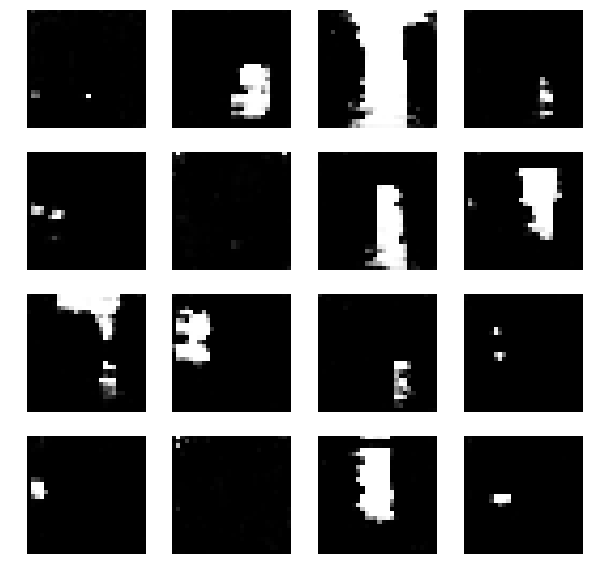

_loss_generator: 19.915703 _loss_discriminator_real: 2.2967951 _loss_discriminator_fake: 10.279461


In [22]:
for i in range(10000):
    _, __, _loss_discriminator_real, _loss_discriminator_fake = run_session_train_discriminator()
    _, _loss_generator = run_session_train_generator()
    
    if i%10==0:
        _generate_image = run_session_test()
        display.clear_output()
        plot_batch_images(_generate_image)
        print('_loss_generator:',_loss_generator, 
              '_loss_discriminator_real:', _loss_discriminator_real, 
              '_loss_discriminator_fake:', _loss_discriminator_fake)
        